# Imports

In [3]:
import numpy as np

from gtda.homology import VietorisRipsPersistence
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from gtda.diagrams import BettiCurve, PersistenceLandscape, PairwiseDistance, PersistenceEntropy
from gtda.plotting import plot_point_cloud, plot_diagram
from gtda.pipeline import Pipeline
import gtda
from sklearn.ensemble import RandomForestClassifier

from pathlib import Path
from sklearn.datasets import make_circles
import plotly.graph_objects as go

import nolds
from GP_algorythm import grassberg_procaccia
from statsmodels.graphics.tsaplots import plot_acf

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics import tsaplots

from scipy.fft import fft, fftfreq

import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [4]:
PATH = Path("../data")

`anglez` - As calculated and described by the GGIR package, z-angle is a metric derived from individual accelerometer components that is commonly used in sleep detection, and refers to the angle of the arm relative to the vertical axis of the body


`enmo` - As calculated and described by the GGIR package, ENMO is the Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features

In [5]:
# train_series = get_data_from_pq_to_pd(r'/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet', 1)
train_series = pd.read_csv(PATH / 'train_series.csv')
train_series.head()

,Unnamed: 0,series_id,step,timestamp,anglez,enmo
0,0,038441c925bb,0,2018-08-14 15:30:00-04:00,2.6367,0.0217
1,1,038441c925bb,1,2018-08-14 15:30:05-04:00,2.6368,0.0215
2,2,038441c925bb,2,2018-08-14 15:30:10-04:00,2.6370,0.0216
3,3,038441c925bb,3,2018-08-14 15:30:15-04:00,2.6368,0.0213
4,4,038441c925bb,4,2018-08-14 15:30:20-04:00,2.6368,0.0215


In [6]:
train_series.drop(["series_id", "Unnamed: 0", "step"], axis=1, inplace=True)

In [7]:
train_series["timestamp"] = pd.to_datetime(train_series["timestamp"])

In [8]:
train_series.head()

,timestamp,anglez,enmo
0,2018-08-14 15:30:00-04:00,2.6367,0.0217
1,2018-08-14 15:30:05-04:00,2.6368,0.0215
2,2018-08-14 15:30:10-04:00,2.6370,0.0216
3,2018-08-14 15:30:15-04:00,2.6368,0.0213
4,2018-08-14 15:30:20-04:00,2.6368,0.0215


In [9]:
train_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389880 entries, 0 to 389879
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype                    
---  ------     --------------   -----                    
 0   timestamp  389880 non-null  datetime64[ns, UTC-04:00]
 1   anglez     389880 non-null  float64                  
 2   enmo       389880 non-null  float64                  
dtypes: datetime64[ns, UTC-04:00](1), float64(2)
memory usage: 8.9 MB


# TDA

## Временные ряды

In [10]:
anglez_series = train_series["anglez"].to_numpy()[1000:4000] # train_series[train_series.series_id == '038441c925bb'].anglez
enmo_series = train_series["enmo"].to_numpy()[:2000]

In [11]:
fig = go.Figure(data=go.Scatter(y=anglez_series))
fig.update_layout(xaxis_title="Timestamp", yaxis_title="Anglez")
fig.show()

### Определение параметров 

#### Определение временной задержки

##### Autocorr function

In [12]:
#plot autocorrelation function
max_delay = 500
acf_y = acf(anglez_series, nlags=max_delay)
# acf_x = range(max_delay + 1)

fig = go.Figure(data=go.Scatter(y=acf_y))
fig.update_layout(xaxis_title="Time delay", yaxis_title="Autocorr function")
fig.show()

##### FFT 

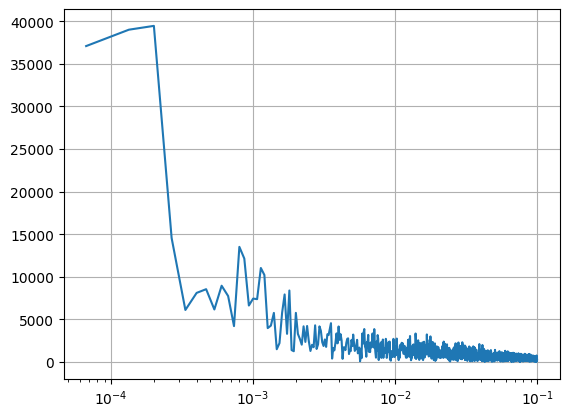

In [13]:

# Number of sample points
N = anglez_series.shape[0]
SAMPLE_RATE = 1 / (train_series["timestamp"][1] - train_series["timestamp"][0]).total_seconds()


yf = fft(anglez_series)[1:N//2]
xf = fftfreq(N, d=1/SAMPLE_RATE)[1:N//2]

plt.plot(xf, np.abs(yf))
plt.xscale('log')
plt.grid()
plt.show()


#### Размерность вложения

##### Метод корреляционной размерности (Метод Грассберга-Прокаччи)

In [14]:
def get_corr_dims(data, dims: list[int]) -> list[int]:
    corr_dims_list = []
    for embd_dim in tqdm(dims):
        corr_dim = nolds.corr_dim(data, embd_dim)
        corr_dims_list.append(corr_dim)
    return corr_dims_list

 71%|███████   | 42/59 [00:49<00:22,  1.33s/it]d:\Projects\PythonProjects\TDA_Uni\.venv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

 78%|███████▊  | 46/59 [00:59<00:31,  2.45s/it]d:\Projects\PythonProjects\TDA_Uni\.venv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

 85%|████████▍ | 50/59 [01:11<00:25,  2.79s/it]d:\Projects\PythonProjects\TDA_Uni\.venv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

d:\Projects\PythonProjects\TDA_Uni\.venv\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

 88%|████████▊ | 52/59 [01:17<00:20,  2.91s/it]d:\Projects\PythonProjects\TDA_Uni\.venv\lib\site-packages\sklearn\metrics\_regression.py:796: U

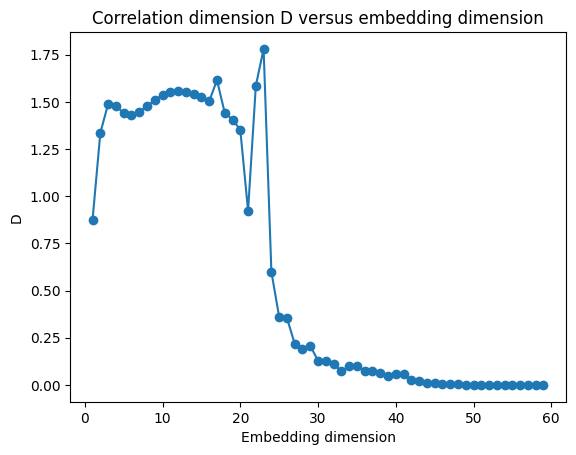

In [17]:
# Calculates the correlation dimension with the Grassberger-Procaccia algorithm
embd_dims_list = list(range(1, 60))
corr_dims = get_corr_dims(anglez_series, embd_dims_list)


plt.plot(embd_dims_list, corr_dims, 'o-')
plt.xlabel("Embedding dimension")
plt.ylabel("D")
plt.title("Correlation dimension D versus embedding dimension")
plt.show()


In [16]:
takens_embedding_optimal_parameters(anglez_series, max_time_delay=50, max_dimension=30,  n_jobs=1)

(47, 7)

## Embeddings

In [ ]:

embedding_dimension_periodic = 17
embedding_time_delay_periodic = 20

embedder = SingleTakensEmbedding(
    parameters_type="fixed",
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=500 # Иначе слишком много значений, и вычисления не произвести
)

anglez_point_cloud = embedder.fit_transform(anglez_series)
enmo_point_cloud = embedder.fit_transform(enmo_series)

In [ ]:
anglez_point_cloud.shape

(780, 17)

In [ ]:
plot_point_cloud(anglez_point_cloud).show()

In [ ]:
# 0 - connected components, 1 - loops, 2 - voids
homology_dimensions = [0, 1, 2]

persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions
)

In [ ]:
diagrams = persistence.fit_transform([anglez_point_cloud, enmo_point_cloud])

In [ ]:
VR = VietorisRipsPersistence()
VR.plot(diagrams, sample=0)

In [ ]:
VR.plot(diagrams, sample=1)

In [ ]:
p_W = 2
PD = PairwiseDistance(metric='wasserstein',
                      metric_params={'p': p_W, 'delta': 0.1},
                      order=None)

PD.fit_transform(diagrams)

array([[[   0.        ,    0.        ,    0.        ],
        [1091.25707317,   46.96343446,    4.95814048]],

       [[1091.12925781,   46.96343446,    4.95814048],
        [   0.        ,    0.        ,    0.        ]]])

In [ ]:
PD = PairwiseDistance(metric='bottleneck',
                      metric_params={'delta': 0.1},
                      order=None)

PD.fit_transform(diagrams)

array([[[ 0.        ,  0.        ,  0.        ],
        [27.94665686,  6.22183067,  1.03077694]],

       [[28.82816498,  6.30248683,  1.03302296],
        [ 0.        ,  0.        ,  0.        ]]])

In [ ]:
BC = BettiCurve()
betti_curves = BC.fit_transform(diagrams)

In [ ]:
BC.plot(betti_curves, sample=0)

In [ ]:
BC.plot(betti_curves, sample=1)

In [ ]:
PD = PairwiseDistance(metric='betti',
                      metric_params={'p': 1},
                      order=None)

PD.fit_transform(diagrams)

array([[[   0.        ,    0.        ,    0.        ],
        [4596.07099302,  375.8576501 ,   15.13717679]],

       [[4596.07099302,  375.8576501 ,   15.13717679],
        [   0.        ,    0.        ,    0.        ]]])

In [ ]:
PL = PersistenceLandscape()
persistence_landscapes = PL.fit_transform(diagrams)

In [ ]:
PL.plot(persistence_landscapes, sample=0)

In [ ]:
PL.plot(persistence_landscapes, sample=1)

In [ ]:
PD = PairwiseDistance(metric='landscape',
                      metric_params={'p': 1},
                      order=None)

PD.fit_transform(diagrams)

array([[[  0.        ,   0.        ,   0.        ],
        [735.47686142, 101.94477384,   2.70576992]],

       [[735.47686142, 101.94477384,   2.70576992],
        [  0.        ,   0.        ,   0.        ]]])

# Машинное обучение

In [ ]:
# Track connected components, loops, and voids
homology_dimensions = [0, 1, 2]

# Collapse edges to speed up H2 persistence calculation!
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    collapse_edges=True,
)

diagrams_basic = persistence.fit_transform(point_clouds_basic)

In [ ]:
# Circle
plot_diagram(diagrams_basic[0])

In [ ]:
#spheres
plot_diagram(diagrams_basic[10])

In [ ]:
#tori
plot_diagram(diagrams_basic[-1])

In [ ]:
persistence_entropy = PersistenceEntropy()

# calculate topological feature matrix
X_basic = persistence_entropy.fit_transform(diagrams_basic)

In [ ]:
plot_point_cloud(X_basic)

In [ ]:
rf = RandomForestClassifier(oob_score=True)
rf.fit(X_basic, labels_basic)

print(f"OOB score: {rf.oob_score_:.3f}")

In [ ]:
steps = [
    ("persistence", VietorisRipsPersistence(metric="euclidean", homology_dimensions=homology_dimensions, n_jobs=6)),
    ("entropy", PersistenceEntropy()),
    ("model", RandomForestClassifier(oob_score=True)),
]

pipeline = Pipeline(steps)

pipeline.fit(point_clouds_basic, labels_basic)

Pipeline(steps=[('persistence',
                 VietorisRipsPersistence(homology_dimensions=[0, 1, 2])),
                ('entropy', PersistenceEntropy()),
                ('model', RandomForestClassifier(oob_score=True))])

pipeline["model"].oob_score_

Julia + Eirene

In [ ]:
x = Main.rand(3,50)
plot_point_cloud(x.T)

In [ ]:
C = Main.eirene(x, model = "pc")

In [ ]:
A0 = Main.barcode(C, dim=0)
A0 = np.append(np.array(A0), np.zeros((len(A0), 1)), axis= 1 )
A0 = np.delete(A0, -1, 0)

In [ ]:
A1 = Main.barcode(C, dim=1)
A1 = np.append(np.array(A1), np.ones((len(A1), 1)), axis= 1 )

In [ ]:
A = np.concatenate((A0, A1), axis=0)
plot_diagram(A)

In [ ]:
Main.wasserstein_distance(dgm1, dgm2, q=q, p=p)

In [ ]:
Main.betticurve(C, dim=0)

In [ ]:
Main.betticurve(C, dim=1)

In [ ]:
BC = BettiCurve()
betti_curves = BC.fit_transform([A])
BC.plot(betti_curves, sample=0)

In [ ]:
Main.classrep(C, dim=1)

In [ ]:
Main.classrep(C, dim=0)

In [ ]:
Main.classrep(C, dim=0, class=1)